In [4]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import sys

sys.path.append(os.path.join("EigenFit"))

## Required packages:
## pip install BaselineRemoval
## pip install lmfit

import EigenFit as eig
import CellData as cell

# Importing the sample data
Loading the data into a dictionary called 'data', with the form:
$\verb|data = {"discharge1": eig.MapSeries}|$

In [10]:
data = dict([(name, eig.MapSeries(os.path.join("example_data", "RawData", name))) 
              for name in os.listdir(os.path.join("example_data", "RawData")) if "charge" in name])

Clipping the spectra in each MapSeries object into a region of interest between 100 cm-1 and 1000 cm-1

In [26]:
for keys, values in data.items():
    values.set_clip_range(100, 1000)

## Removing the cosmic rays

The following cosmic ray dictionaries are saved, then reloaded by the $\verb|CellData|$ process below.

The cosmic rays stand out clearly, so can be identified by eye. The spectra acquired at each (x, y) position for each voltage (indicated by different colours and markers) are overlaid, with the (x, y) position shown to the left of the graph. Different subsets of the (x, y) positions can be viewed by moving the sliders at the bottom. 

An example of the cosmic ray removal dictionary is shown below. Each voltage (i.e. each map) where cosmic rays are present contains a dictionary listing the cosmic rays, where the $\verb|x_pos|$ and $\verb|y_pos|$ refer to the map positions (see left of spectra), the $\verb|spike_pos|$ refers to the wavenumber of the spike (hovering over the graph will indicate the wavenumber as 'x' in the bottom right of the graph view window, below the legend) and 'spike width' will usually be 5 (increase for wider/ overlapping spikes)

Note that lines with the same colour have uniquely identifying markers.

If the widget display is slow, try re-running the cell that generates the widget to 'refresh' it

In [47]:
discharge1_CREs = {'voltage': [1.675, 1.739, 1.933, 1.933, 2.064],
 'x_pos': [1, 15, 1, 0, 12],
 'y_pos': [19, 17, 4, 13, 18],
 'spike_pos': [806, 856, 651, 719, 179],
 'smooth_width': [5, 5, 5, 5, 5]}

charge1_CREs = {'voltage': [2.141, 2.535, 2.535, 2.009, 2.732, 2.206, 2.076],
 'x_pos': [2, 1, 6, 7, 7, 1, 0],
 'y_pos': [0, 8, 8, 16, 17, 16, 16],
 'spike_pos': [522, 221, 1000, 345, 366, 900, 456],
 'smooth_width': [5, 5, 5, 5, 5, 5, 5]}

charge4_CREs = {'voltage': [1.605, 2.196, 2.8, 2.649, 1.866, 2.448, 2.8, 2.678, 2.678, 2.124, 2.611],
 'x_pos': [6, 17, 14, 0, 12, 5, 6, 13, 7, 5, 7],
 'y_pos': [1, 0, 4, 5, 3, 8, 7, 10, 15, 20, 18],
 'spike_pos': [279, 414, 970, 563, 547, 897, 483, 350, 308, 470, 393],
 'smooth_width': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]}

In [37]:
if "CRE_manual_selection" not in os.listdir("example_data"):
    os.makedirs(os.path.join("example_data", "CRE_manual_selection"))
np.save(os.path.join("example_data", "CRE_manual_selection", "discharge1.npy"), discharge1_CREs, allow_pickle=True)
np.save(os.path.join("example_data", "CRE_manual_selection", "charge1.npy"), charge1_CREs, allow_pickle=True)
np.save(os.path.join("example_data", "CRE_manual_selection", "charge4.npy"), charge4_CREs, allow_pickle=True)

<IPython.core.display.Javascript object>


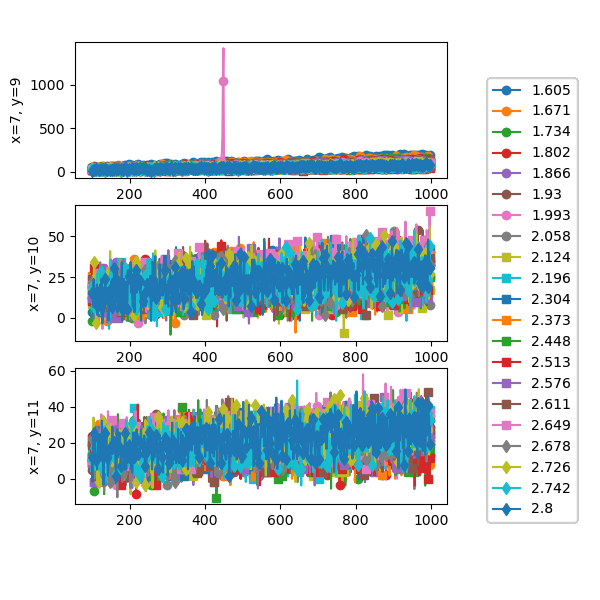

interactive(children=(IntSlider(value=0, description='seg_id', max=6), IntSlider(value=0, description='x', max…

(<Figure size 600x600 with 3 Axes>,
 array([<AxesSubplot:ylabel='x=0, y=0'>, <AxesSubplot:ylabel='x=0, y=1'>,
        <AxesSubplot:ylabel='x=0, y=2'>], dtype=object))

In [40]:
data["charge4"].cosmic_ray_view()

# Dimension reduction

On first run: Removes the background and normalises the spectra (saves as pre-processed data for future use to save time)
Background is removed using the $\verb|BaselineRemoval|$ package (see https://pypi.org/project/BaselineRemoval/)

The results are saved to the path of the original data (here 'example_data') in a new folder called 'processed_data'

In [48]:
dim_red = dict([(keys, eig.SeriesDimensionReduction(values)) for keys, values in data.items()])

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Apply the PCA operator (the number of components is quite arbitrary: 3 is generally sufficient for the test data, but more may be required)

In [51]:
[values.perform_pca(n_components=10) for values in dim_red.values()];

<IPython.core.display.Javascript object>


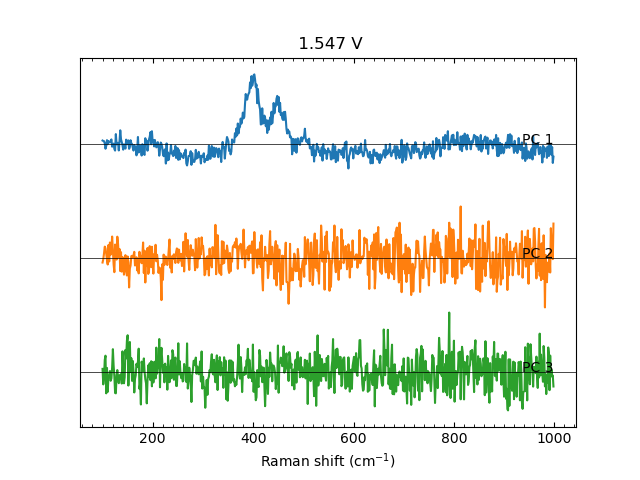

interactive(children=(IntSlider(value=0, description='v_idx', max=13), FloatSlider(value=0.3, description='off…

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':' 1.547 V'}, xlabel='Raman shift (cm$^{-1}$)'>)

In [52]:
dim_red["discharge1"].visualise_components()

Select the peaks for each voltage using the widget, and remember to save the results

To ensure the $\verb|CellData|$ object can `find' the results, it they should be saved in the following format: 

<discharge/ charge label><cycle number>_pc<principal component number>_sp

(discharge label = d, charge label = c)

So for the first principal component of the first discharge: "d1_pc1_sp"

In [63]:
d1_pc1_sp = eig.SelectPeaks(voltage_series=dim_red["discharge1"].voltage,
                            reload=os.path.join("example_data", "selected_peaks", "d1_pc1_sp.npy"))

In [64]:
d1_pc1_sp.grid

In [71]:
d1_pc1_sp.get_checkbox_values(save_name="d1_pc1_sp", save_path=os.path.join("example_data", "selected_peaks"))

In [75]:
select_peaks_links = {"discharge1": "d1",
                      "charge1": "c1",
                      "charge4": "c4"}

In [76]:
for name in select_peaks_links.keys():
    print([fname for fname in os.listdir(os.path.join("example_data", "selected_peaks")) if fname.split("_")[0]==select_peaks_links[name]])

['d1_pc1_sp.npy', 'd1_pc2_sp.npy']
['c1_pc1_sp.npy', 'c1_pc2_sp.npy']
['c4_pc1_sp.npy', 'c4_pc2_sp.npy']


In [77]:
select_peaks = dict([(name, [eig.SelectPeaks(voltage_series=dim_red[name].voltage,
                                             reload=os.path.join("example_data", "selected_peaks", fname))
                            for fname in os.listdir(os.path.join("example_data", "selected_peaks")) if 
                             fname.split("_")[0]==select_peaks_links[name]])
                    for name in select_peaks_links.keys()])

In [81]:
[[sp_obj.get_checkbox_values() for sp_obj in values] for values in select_peaks.values()]

[[None, None], [None, None], [None, None]]

# Linear combination fit

In [85]:
fit_results = dict([(keys, eig.FitResults(DimRed_object=values, SelectPeaks_objects=select_peaks[keys]))
                     for keys, values in dim_red.items() if keys in select_peaks.keys()])

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


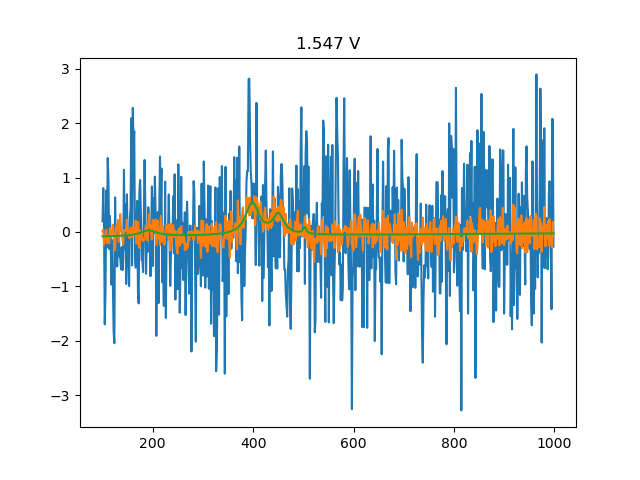

interactive(children=(IntSlider(value=0, description='x', max=20), IntSlider(value=0, description='y', max=20)…

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:title={'center':'1.547 V'}>)

In [87]:
fit_results["discharge1"].plot_fit_results()

# Reloading and analysing the data

The data and pre-processing outputs above, corresponding to the LCF process, can be re-loaded into the CellData object.
This object includes the data from all available cycles, and incorporates functions for 1-pass fitting (time consuming), 2-pass fitting (faster), and KNN filtering

Note: also seems to run LCF when loaded

In [66]:
sample = cell.CellData(os.path.join("example_data"))

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

## 1PF
On the first run, this will fit the same composite model to all positions and save the results to the '1_pass_fit' folder in the data directory

In [93]:
sample.one_pass_fit("discharge1")

2.39
2.326
2.259
2.195
2.131
2.064
2.0
1.933
1.868
1.803
1.739
1.675
1.611
1.547


## 2PF 
On the first run, this will run the two-pass fit procedure using the LCF results

On subsequent runs, the saved results will be reloaded to an attribute of sample labelled as the cycle number. 

For example, running:

$\verb|sample.two_pass_fit("discharge1")|$

Produces results which can be accessed via 

$\verb|sample.discharge1|$

In [95]:
sample.two_pass_fit("discharge1")

1.547
1.611
1.675
1.739
1.803
1.868
1.933
2.0
2.064
2.131
2.195
2.259
2.326
2.39


In [109]:
sample.knn_select("discharge1", n_training_spectra=200)

<IPython.core.display.Javascript object>


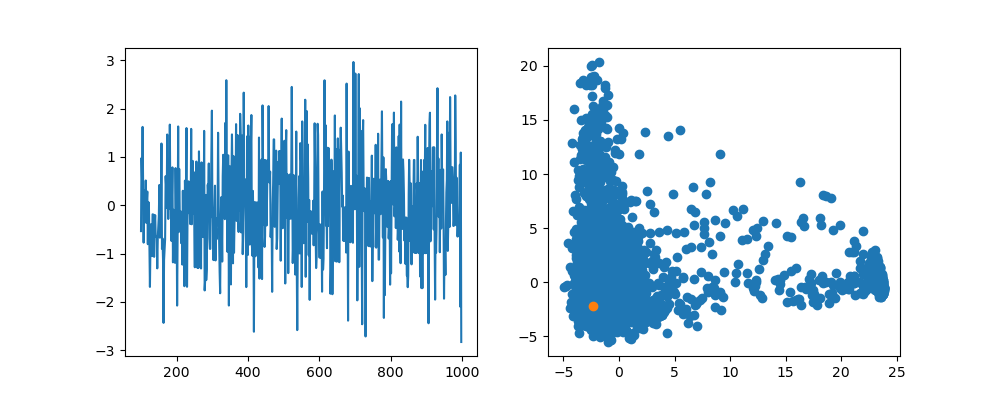

interactive(children=(IntSlider(value=0, description='idx', max=199), Output()), _dom_classes=('widget-interac…

In [110]:
sample.KNN.discharge1.peak_select_viewer()

In [111]:
sample.KNN.discharge1.label_lists.update([("sulfur", [16, 21, 29, 38, 85, 108, 111, 119, 122, 142, 155, 160, 181])])
sample.KNN.discharge1.label_lists.update([("PS_weak", [12, 13, 26, 146, 176, 190, 196, ])])
sample.KNN.discharge1.label_lists.update([("PS", [36, 101, 125])])
sample.KNN.discharge1.label_lists.update([("mixed", [155, 181, ])])

In [121]:
sample.KNN.discharge1.fit_model("sulfur")
sulfur_predict_d1 = sample.KNN.discharge1.predict_dict

<IPython.core.display.Javascript object>


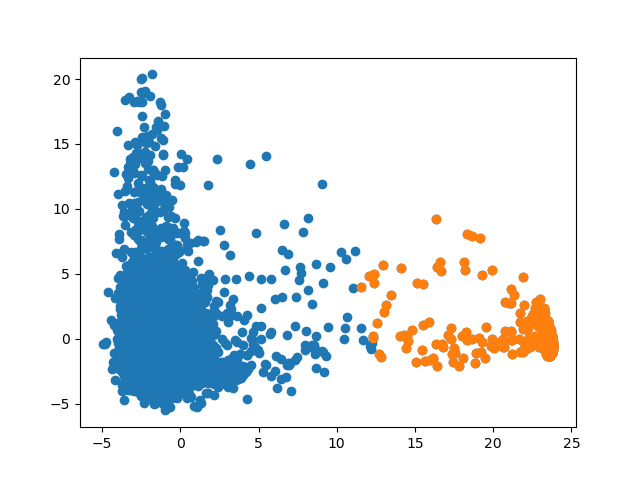

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [122]:
sample.KNN.discharge1.check_fit()

In [123]:
sample.KNN.discharge1.fit_model("PS")
PS_predict_d1 = sample.KNN.discharge1.predict_dict

sample.KNN.discharge1.fit_model("mixed")
mixed_predict_d1 = sample.KNN.discharge1.predict_dict

all_peaks =np.unique(np.hstack([[*voltage_values.keys()] for voltage_values in sample.discharge1.values.values()]))

In [125]:
d1_intensities = dict([(voltage, 
                     dict([(peak, peak_vals["amplitude"]/np.pi/peak_vals["sigma"])
                           for peak, peak_vals in voltage_vals.items()]))
                     for voltage, voltage_vals in sample.discharge1.values.items()])

In [126]:
x_extent = sample.dim_red["discharge1"].common.x_extent
y_extent = sample.dim_red["discharge1"].common.y_extent
shift_extent = sample.dim_red["discharge1"].common.shift_extent




volt_max = 2.8
volt_min = 1.5
peak_plots = [218, 398, 450]

for peak in peak_plots:
    for voltage in sulfur_predict_d1.keys():
        if peak not in d1_intensities[voltage].keys():
            d1_intensities[voltage].update([(peak, np.full((x_extent, y_extent), np.nan))])

In [119]:
from MultiCycVolt import CycVolt

In [134]:
cv = CycVolt(os.path.join("example_data", "electrochemistry", 
                          '25T_insitu_cGFc_200uL_1mm_3-1mg_211013_02_CV_C01.mpt'))
from mpt_to_df import mpt_to_df
cv_full = mpt_to_df(os.path.join("example_data", "electrochemistry", 
                          '25T_insitu_cGFc_200uL_1mm_3-1mg_211013_02_CV_C01.mpt'))

def discharge_voltages(cycle, voltage_list):
    voltages = np.sort(voltage_list)[::-1]
    return (2*cycle-1)*(volt_max-volt_min)-(voltages-volt_min)

def charge_voltages(cycle, voltage_list):
    voltages = np.sort(voltage_list)
    return (2*cycle-1)*(volt_max-volt_min)+(voltages-volt_min)

In [127]:
bp_volts = np.hstack((discharge_voltages(1, [*d1_intensities.keys()])))

In [128]:
min_step = np.nanmin(bp_volts[1:]-bp_volts[:-1])
offsets = np.linspace(-min_step/2, min_step/2, len(peak_plots)+2)[1:-1]
width = min_step/(len(peak_plots)+2)

In [129]:
color_dict = {218: plt.cm.Dark2(1),
              398: plt.cm.Dark2(0),
              450: plt.cm.Dark2(2)}

In [130]:
def make_intensities(intensity_data, predict_dict, discharge=True, peak_plots=[218, 398, 450]):
    
    if discharge==True:
        voltages = np.sort([*intensity_data.keys()])[::-1]
    else:
        voltages = np.sort([*intensity_data.keys()])
        
    bp_i = dict([(peak, dict([(voltage, np.full((x_extent, y_extent), np.nan)) 
                              for voltage in voltages]))
                for peak in peak_plots])
        
    for peak in peak_plots:
        for voltage in voltages:
            if peak in np.sort([*intensity_data[voltage].keys()])[::-1]:
                bp_i[peak][voltage] = intensity_data[voltage][peak][predict_dict[voltage]==1][
                                np.isfinite(intensity_data[voltage][peak][predict_dict[voltage]==1])
                ]
    return bp_i

In [131]:
bp_d1_i_s8 = make_intensities(d1_intensities, sulfur_predict_d1)


In [132]:
bp_d1_i = {218: bp_d1_i_s8[218],
           398: dict([(key, np.array([])) for key in bp_d1_i_s8[398].keys()]),
           450: dict([(key, np.array([])) for key in bp_d1_i_s8[450].keys()])}


In [135]:
voltage = np.array(cv_full["Ewe/V"])
current = np.array(cv_full["<I>/mA"])
dV = voltage[1:]-voltage[:-1]
cathodic = np.argwhere(np.sign(dV)==-1).flatten()
breakpoints = [c for nc, c in enumerate(cathodic[1:]) if cathodic[nc+1]-cathodic[nc] != 1 ]

In [136]:
lims_0 = [np.min(discharge_voltages(1, cv.discharge.voltage[0]))-0.1, 
          np.max(discharge_voltages(1, cv.discharge.voltage[0]))+0.1]
lims_1 = [np.min(discharge_voltages(3, cv.discharge.voltage[2]))-0.1,
          np.max(discharge_voltages(4, voltage[breakpoints[-1]:]))+0.1]

total_width = (lims_0[1]-lims_0[0])+(lims_1[1]-lims_1[0])

<IPython.core.display.Javascript object>


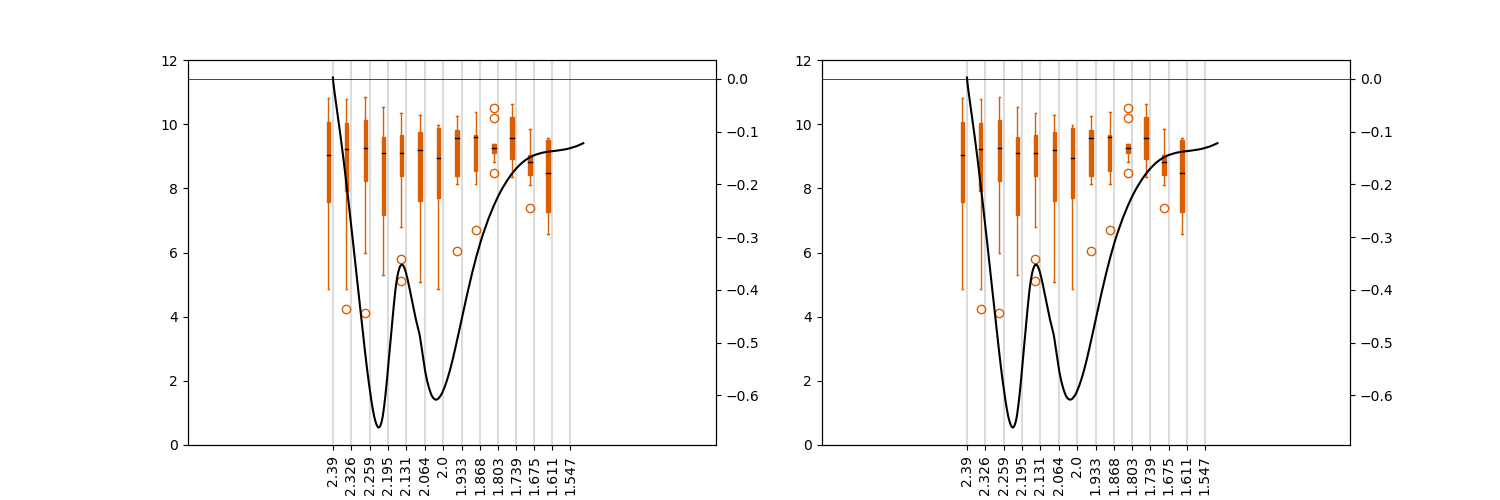

In [141]:
f, (axes_i) = plt.subplots(1, 2, figsize=(15, 5))
axes_cv = []
for ax in axes_i:
    axes_cv.append(ax.twinx())
axes_cv = np.array(axes_cv)

voltage_ticks = np.hstack((discharge_voltages(1, [*d1_intensities.keys()]),
                          ))

for i in range(2):
    bplot_dict_d1 = {}
    ax_i = axes_i[i]
    ax_cv = axes_cv[i]
    
    for npeak, peak in enumerate(peak_plots):
        bplot_dict_d1.update([(peak, ax_i.boxplot([*bp_d1_i[peak].values()],
                  positions=discharge_voltages(1, [*d1_intensities.keys()])+offsets[npeak],
                    widths=width,
                  patch_artist=True))])
    
    for bplot in [bplot_dict_d1]:
        for npeak, peak in enumerate(peak_plots):
            for box in bplot[peak]["boxes"]:
                box.set_facecolor(color_dict[peak])
                box.set_edgecolor(color_dict[peak])
            for line in bplot[peak]["medians"]:
                line.set_color("black")
            for line in bplot[peak]["fliers"]:
                line.set_markeredgecolor(color_dict[peak])
            for line in bplot[peak]["whiskers"]:
                line.set_color(color_dict[peak])
            for line in bplot[peak]["caps"]:
                line.set_color(color_dict[peak])
    ax_cv.plot(discharge_voltages(1, cv.discharge.voltage[0]), cv.discharge.current[0], color="k")
    ax_cv.axhline(0, color="k", lw=0.5)
    
    ax_i.set_xticks(voltage_ticks)
    x_label = np.hstack((np.sort([*d1_intensities.keys()])[::-1],
                        ))
    ax_i.set_xticklabels(x_label, rotation=90);
    ax_i.set_ylim([0, 12])
    [ax_i.axvline(m, color="gainsboro", zorder=0) for m in voltage_ticks]
#     [ax_i.axvline(m+min_step/2, color="blue") for m in voltage_ticks]


# axes_i[0].set_xlim(lims_0)
# axes_i[1].set_xlim(lims_1)
# # axes_i[2].set_xlim(lims_2)

# pos_0 = axes_i[0].get_position()
# margin = 0.01

# width_scaler = 0.8

# axes_i[0].set_position((0.05, 0.15,
#                     width_scaler*(lims_0[1]-lims_0[0])/total_width, 
#                     pos_0.height))
# pos_0 = axes_i[0].get_position()
# axes_i[1].set_position((pos_0.x0+width_scaler*(lims_0[1]-lims_0[0])/total_width+margin,
#                     pos_0.y0, 
#                     width_scaler*(lims_1[1]-lims_1[0])/total_width+margin, pos_0.height))
# # axes_i[2].set_position((pos_0.x0+(width_scaler*(lims_0[1]-lims_0[0])/total_width+margin)+\
# #                     (width_scaler*(lims_1[1]-lims_1[0])/total_width+margin)+margin,
# #                     pos_0.y0,
# #                     (width_scaler*(lims_2[1]-lims_2[0])/total_width),
# #                     pos_0.height))

# for ax in [axes_i[0], axes_cv[0]]:
#     ax.spines["right"].set_visible(False)
#     ax.tick_params(which="both", right=False)
    
# axes_cv[0].set_yticks([])
    
# for ax in [axes_i[1], axes_cv[1]]:
#     ax.spines["left"].set_visible(False)
# #     ax.spines["right"].set_visible(False)
#     ax.tick_params(which="both", right=False, left=False)
#     ax.set_yticks([])
    
# # for ax in [axes_i[2], axes_cv[2]]:
# #     ax.spines["left"].set_visible(False)
# #     ax.tick_params(which="both", left=False)
# # axes_i[2].set_yticks([])

# length = 1  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(marker=[(-1, -length), (1, length)], markersize=12,
#               linestyle="none", color='k', mec='k', mew=1, clip_on=False)
# axes_i[0].plot([1, 1], [1, 0], transform=axes_i[0].transAxes, **kwargs)
# axes_i[1].plot([0, 0], [0, 1], transform=axes_i[1].transAxes, **kwargs)
# # axes_i[1].plot([0, 0, 1, 1], [1, 0, 0, 1], transform=axes_i[1].transAxes, **kwargs)
# # axes_i[2].plot([0, 0], [0, 1], transform=axes_i[2].transAxes, **kwargs)

# axes_i[0].set_ylabel("Normalised peak intensity (a.u.)")
# axes_cv[-1].set_ylabel("Current (mA)")

# axes_i[0].text(x=1.1, y=-0.15, s="Voltage vs. Li/ Li$^{+}$ (V)", transform=axes_i[0].transAxes)

# axes_i[0].set_title("Cathodic sweep 1")
# axes_i[1].set_title("Sweep 3")
